# Notebook for match final results predictions

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pk

#pd.set_option('display.max_rows', )
pd.set_option('display.max_columns', 200)

In [97]:
bm = 'PS'
H = bm + 'H'
D = bm + 'D'
A = bm + 'A'

k = 50.0

def get_best(s):

    h = s.FTHG
    a = s.FTAG

    BH = s[H + '_P']
    BD = s[D + '_P']
    BA = s[A + '_P']

    if BH == max(BH, BD, BA, k) and h > a or \
       BD == max(BH, BD, BA, k) and h == a or \
       BA == max(BH, BD, BA, k) and h < a :
        
        return 1
    
    return 0

In [98]:
filename_1 = "Serie-A-2122.csv"
filename_2 = "Serie-A-2223.csv"
filename_3 = "Premier-league-2122.csv"
filename_4 = "Premier-league-2223.csv"
filename_5 = "Bundesliga-2122.csv"
filename_6 = "Bundesliga-2223.csv"
filename_7 = "Liga-2122.csv"
filename_8 = "Liga-2223.csv"
filename_9  = "Ligue1-2122.csv"
filename_10 = "Ligue1-2223.csv"
filename_11 = "Super-lig-2122.csv"
filename_12 = "Super-lig-2223.csv"
filename_13 = "Eredivise-2122.csv"
filename_14 = "Eredivise-2223.csv"
filename_15 = "Liga-1-2122.csv"
filename_16 = "Liga-1-2223.csv"
filename_17 = "Serie-A-2021.csv"

In [99]:
#Loading the datasets

filenames = [filename_1, filename_2, filename_3, filename_4,
             filename_5, filename_6, filename_7,
             filename_8, filename_9, filename_10,
             filename_11, filename_12, filename_13,
             filename_14, filename_15, filename_16,
             filename_17]

tmp_features = ['HomeTeam','AwayTeam','FTHG','FTAG', H, D, A]

df = pd.DataFrame()
for name in filenames:
    tmp = pd.read_csv(name, sep=',')
    df = pd.concat([df, tmp[tmp_features]])
df.shape

(5390, 7)

Create the result_index

In [100]:
df[H + '_P'] = round(100/(1 + df[H]*(1/df[D] + 1/df[A])), 2)
df[A + '_P'] = round(100/(1 + df[A]*(1/df[H] + 1/df[D])), 2)
df[D + '_P'] = round(100/(1 + df[D]*(1/df[H] + 1/df[A])), 2)

features = [H, D, A]
target   = [bm + '_income_index']

df[bm + '_income_index'] = df.apply(get_best, axis=1)
df[bm + '_income_index'].value_counts()

PS_income_index
0    3616
1    1774
Name: count, dtype: int64

In [101]:
df[df[bm + '_income_index'] == 1][[bm + 'H', bm + 'D', bm + 'A']].apply(lambda x: min(x[bm + 'H'], x[bm + 'D'], x[bm + 'A']), axis=1).mean()

1.5300732807215331

In [102]:
df.dropna(inplace=True)

Da notare che è piu importante il valore della precision sugli 1.

### Data preparation

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = np.concatenate((df[features].to_numpy(), df[features].to_numpy()))
y = np.concatenate((df[target].to_numpy(),   df[target].to_numpy())).squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### KNN

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1465
           1       0.74      0.82      0.78       682

    accuracy                           0.85      2147
   macro avg       0.83      0.84      0.83      2147
weighted avg       0.86      0.85      0.85      2147



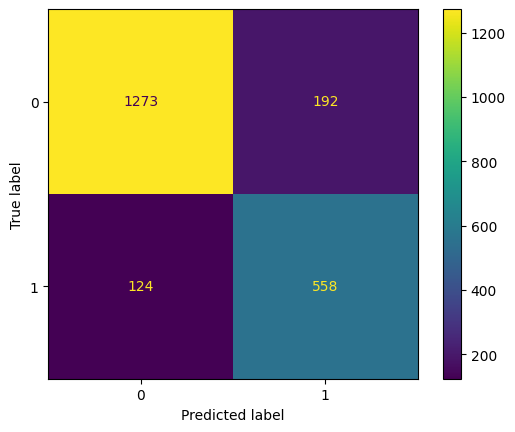

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Create Decision Tree classifer object
clf = KNeighborsClassifier(n_jobs=-1)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Hyperparameter tuning

In [83]:
from sklearn.model_selection import GridSearchCV
#######################
### K-Nearest Neighbors
#######################
estimator_KNN = KNeighborsClassifier()
parameters_KNN = {
    'n_neighbors': (1,30, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
    'algorithm': ('brute', 'kd_tree', 'ball_tree')
}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'f1_weighted',
    n_jobs = -1,
    cv = 5
)

grid_search_KNN.fit(X, y)
#Documentation of tuneable parameters:
#class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', 
#                                             algorithm='auto', leaf_size=30, p=2, 
#                                             metric='minkowski', metric_params=None, 
#                                             n_jobs=None, **kwargs)

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search_KNN.best_params_)

Best hyperparameters: {'algorithm': 'kd_tree', 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1465
           1       0.93      0.95      0.94       682

    accuracy                           0.96      2147
   macro avg       0.95      0.96      0.96      2147
weighted avg       0.96      0.96      0.96      2147



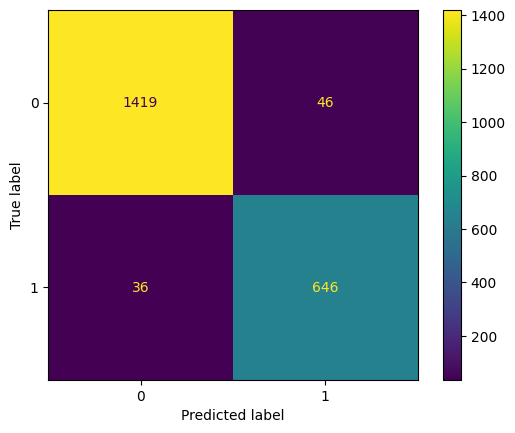

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Create Decision Tree classifer object
clf = KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, metric='minkowski', n_neighbors=1, p=1, weights='uniform', n_jobs=-1)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [37]:
import plotly.graph_objs as go

# Colori per i valori di y_train
colors = ['red' if y == 0 else 'blue' if y==1 else 'black' for y in np.concatenate((y_train, [2]))]

X_train = np.append(X_train, [[8.32, 5.37, 1.38]], axis=0)

# Creazione della traccia dello scatter 3D
trace = go.Scatter3d(
    x=X_train[:,0],
    y=X_train[:,1],
    z=X_train[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8,
        colorscale='Viridis'
    )
)

# Layout del grafico
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='H'),
        yaxis=dict(title='D'),
        zaxis=dict(title='A')
    ),
    width=1500,  # Imposta la larghezza della figura a 800 pixel
    height=800  # Imposta l'altezza della figura a 800 pixel
)

# Creazione della figura
fig = go.Figure(data=[trace], layout=layout)

# Visualizzazione della figura
fig.show()

<img src="knn-plot.png">

Salvo il modello

In [95]:
import pickle as pk

# Create Decision Tree classifer object
clf = KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, metric='minkowski', n_neighbors=1, p=1, weights='uniform', n_jobs=-1)

# Train Decision Tree Classifer
clf = clf.fit(X, y)

pk.dump(clf, open("knn-model.sav", 'wb'))

## Bruteforce test

In [88]:
len(np.arange(1.00, 5.00, 0.05))

80

In [49]:
X = np.empty(shape=(0, 3))
i = 0
c = len(np.arange(1.00, 5.00, 0.2)) ** 3
for h in np.arange(1.00, 5.00, 0.2):
    for d in np.arange(1.00, 5.00, 0.2):
        for a in np.arange(1.00, 5.00, 0.2):

            i += 1

            tot = round(100/(1 + h*(1/d + 1/a)), 5) + round(100/(1 + d*(1/h + 1/a)), 5) + round(100/(1 + a*(1/h + 1/d)), 5)

            if tot > 99.99 and tot < 102.00 and min(h, d, a) < 3.00:
                X = np.append(X, [[h, d, a]], axis=0)
                print("Step: ", i, "of", c)

Step:  1 of 8000
Step:  2 of 8000
Step:  3 of 8000
Step:  4 of 8000
Step:  5 of 8000
Step:  6 of 8000
Step:  7 of 8000
Step:  8 of 8000
Step:  9 of 8000
Step:  10 of 8000
Step:  11 of 8000
Step:  12 of 8000
Step:  13 of 8000
Step:  14 of 8000
Step:  15 of 8000
Step:  16 of 8000
Step:  17 of 8000
Step:  18 of 8000
Step:  19 of 8000
Step:  20 of 8000
Step:  21 of 8000
Step:  22 of 8000
Step:  23 of 8000
Step:  24 of 8000
Step:  25 of 8000
Step:  26 of 8000
Step:  27 of 8000
Step:  28 of 8000
Step:  29 of 8000
Step:  30 of 8000
Step:  31 of 8000
Step:  32 of 8000
Step:  33 of 8000
Step:  34 of 8000
Step:  35 of 8000
Step:  36 of 8000
Step:  37 of 8000
Step:  38 of 8000
Step:  39 of 8000
Step:  40 of 8000
Step:  41 of 8000
Step:  42 of 8000
Step:  43 of 8000
Step:  44 of 8000
Step:  45 of 8000
Step:  46 of 8000
Step:  47 of 8000
Step:  48 of 8000
Step:  49 of 8000
Step:  50 of 8000
Step:  51 of 8000
Step:  52 of 8000
Step:  53 of 8000
Step:  54 of 8000
Step:  55 of 8000
Step:  56 of 8000
S

In [50]:
import pickle as pk
model = pk.load(open("knn-model.sav", 'rb'))

y_pred = model.predict(X)

#X = np.delete(X, np.where(y_pred == 0), axis=0)
#y_pred = np.delete(y_pred, np.where(y_pred == 0), axis=0)

In [27]:
X.shape

(6246, 3)

In [59]:
import plotly.graph_objs as go

# Colori per i valori di y_train
colors = ['red' if i == 0 else 'blue' for i in y_pred]

# Creazione della traccia dello scatter 3D
trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8,
        colorscale='Viridis'
    )
)

# Layout del grafico
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='H'),
        yaxis=dict(title='D'),
        zaxis=dict(title='A')
    ),
    width=1500,  # Imposta la larghezza della figura a 800 pixel
    height=800  # Imposta l'altezza della figura a 800 pixel
)

# Creazione della figura
fig = go.Figure(data=[trace], layout=layout)

# Visualizzazione della figura
fig.show()

In [62]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

# Layout del grafico
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='H'),
        yaxis=dict(title='D'),
        zaxis=dict(title='A')
    ),
    width=1500,  # Imposta la larghezza della figura a 800 pixel
    height=800  # Imposta l'altezza della figura a 800 pixel
)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ), layout=layout)
fig.show()